# Titanic disaster survival prediction.
For deeper introduction on the problem you can go to the link https://www.kaggle.com/c/titanic/submissions

Let's first import some libraries useful for the EDA and some classifiers whose performances in predicting the survival in the test will be compared later in the notebook.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
dirname= './datasets/'
train_df = pd.read_csv(os.path.join(dirname, 'train.csv'))
test_df = pd.read_csv(os.path.join(dirname, 'test.csv'))

In [3]:
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId is, precisely, an id in the database, therefore it is absolutely unrelated to the probability of survival of the corresponding passenger and we can safely drop from both samples.
Furthermore we can see that there are a couple missing values for the predictor *Embarked*, 177 missing values for the *Age* predictor and almost 700 for *Cabin*, we will deal with missing values later in the notebook, but it is good to keep this in mind.

In [5]:
train_df.drop("PassengerId", axis=1, inplace=True)
test_df.drop("PassengerId", axis=1, inplace=True)

As part of the EDA let's check if, in our training sample, there is any correlation between the survival probability and categories like sex, age, class of the room occupied within the boat and the port at which passengers boarded.
To check such correlation we can only use the training sample, where the predictor *Survived* is known 

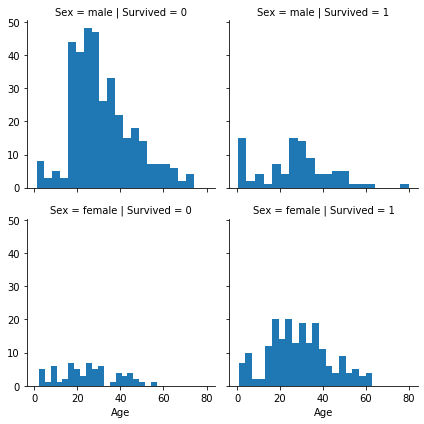

In [6]:
g = sns.FacetGrid(train_df, col='Survived', row='Sex')
g.map(plt.hist, 'Age', bins=20)

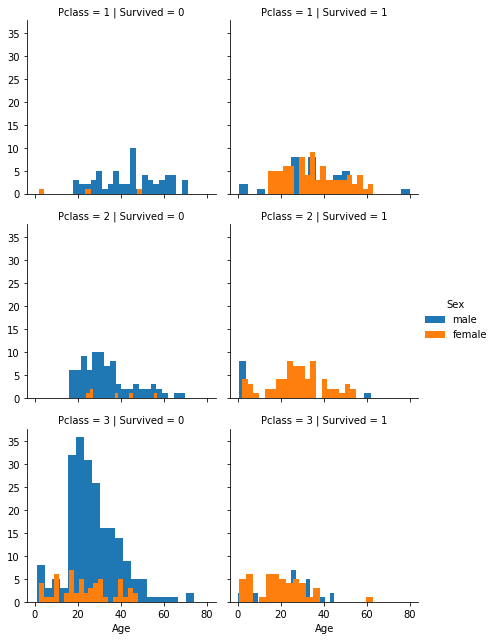

In [8]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', hue='Sex')
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


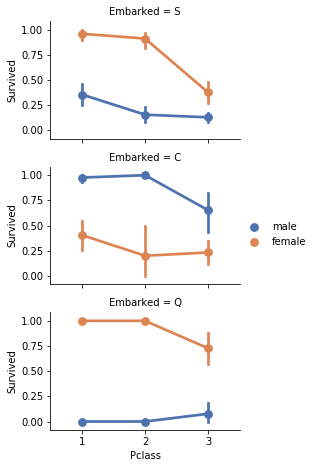

In [9]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


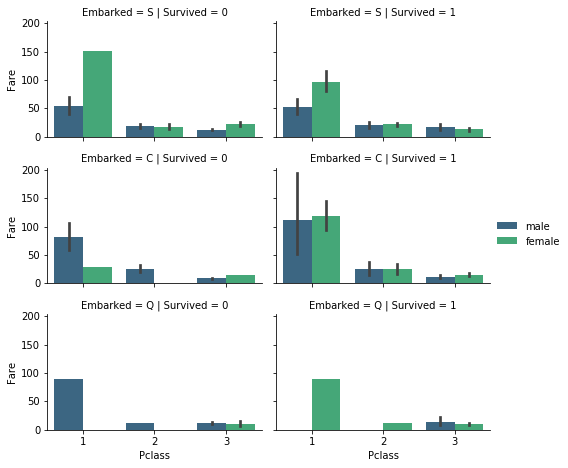

In [10]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Pclass', 'Fare', hue=train_df['Sex'], palette="viridis")
grid.add_legend()

We can see that women were more likely to survive the disaster regardless of Age and class. On the other hand it looks like women who boarded Titanic from Cherbourg (= C, Queenstown = Q and Southampton = S) were more likely to not survive than man, regardles of their social extraction (class number of their cabin).

To replace missing values with some sensible value we can check the **Age** distribution w.r.t. the **Sex** and **Pclass** predictors

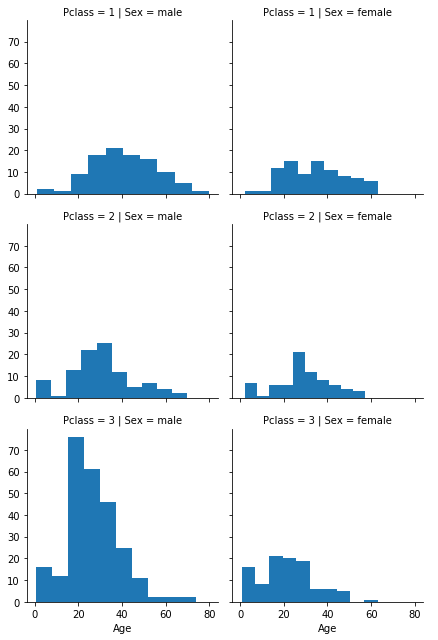

In [12]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex')
grid.map(plt.hist, 'Age')
grid.add_legend()

It is good to also check how the test sample looks like and if we can get more information on the **Age**, **Cabin** and **Embarked** features

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


As we can see **Age** has some missing values, *Fare* has one, while **Cabin** has a lot of missing values.
We will therefore combine the two datasets and fill the missing values based in **Age** based on **Sex** and **Pclass** predictors. 
But first, let's categorise some predictors in a more model-friendly way. 

In [14]:
genders = {"male": 0, "female": 1}
train_df['Sex'] = train_df['Sex'].map(genders)
test_df['Sex'] = test_df['Sex'].map(genders)

In [15]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [16]:
train_df['Embarked']=train_df['Embarked'].fillna('S')

In [17]:
ports = {"S": 0, "C": 1, "Q": 2}
train_df['Embarked'] = train_df['Embarked'].map(ports)
test_df['Embarked'] = test_df['Embarked'].map(ports)

Let's create a new feature **Relatives** by combining the **SibSp** (number of Siblings and Spouses) with the **Parch** (number of parents and children), in this way we may get some feeling on the survival probability for people with a small or big family. 

In [18]:
for dataset in [train_df, test_df]:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


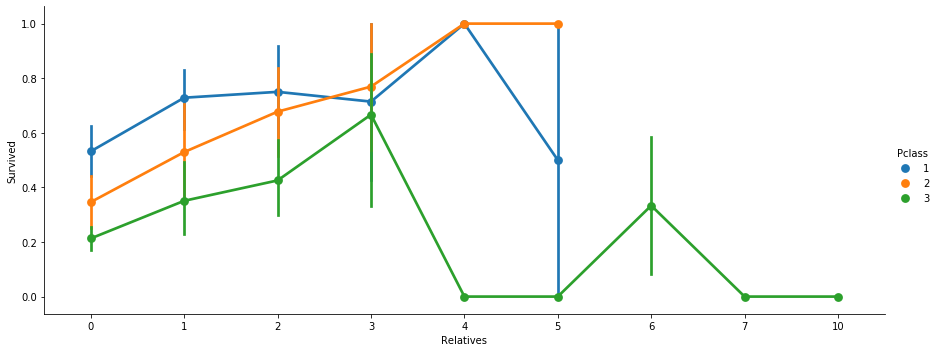

In [21]:
plot = sns.factorplot('Relatives','Survived', hue='Pclass', data=train_df, aspect = 2.5)

As we can see there is a high survival probability for people with smaller families (1<= Relatives < 4) for all three **Pclass** values. Moreover, people with 4 or 5 relatives in first or second class were quite likely to survive, while people who bought a 3rd class ticket and had more than 3 relatives had a very low chance of survival.
We can therefore create the feature **BigFamily** for a passenger based on the number of his/her relatives. 

In [22]:
familySize = { 0:0, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1}
for dataset in [train_df, test_df]:
    dataset['BigFamily'] = dataset['Relatives'].map(familySize)

It is useful to check the **Fare** of the ticket per **Pclass**

[(1, 1000)]

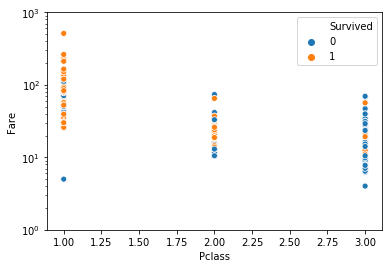

In [23]:
classCost = sns.scatterplot(train_df['Pclass'],train_df['Fare'],hue=train_df['Survived'])
classCost.set(yscale="Log")
classCost.set(ylim= (1,1000))

As we can see, there are some 3rd class tickets that were more expensive than some 2nd and 1st class ones.. 
The most logical explanation for these tickets is that they were *family tickets* and therefore their price was multiplied by the number of relatives in the family.
Let's test this hypothesis with the totality of the data available (train and test) and let's finally deal with missing values for the **Age** and **Fare**

In [24]:
checkName=train_df.copy(deep=True)

In [25]:
checkName=checkName.append(test_df, sort=False, ignore_index=True)

In [26]:
checkName.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Survived     891 non-null float64
Pclass       1309 non-null int64
Name         1309 non-null object
Sex          1309 non-null int64
Age          1046 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Ticket       1309 non-null object
Fare         1308 non-null float64
Cabin        295 non-null object
Embarked     1309 non-null int64
Relatives    1309 non-null int64
BigFamily    1309 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 133.1+ KB


In [27]:
checkName[(checkName["Pclass"] ==3) & (checkName['Fare'].isnull())]

Survived  Pclass                Name  Sex   Age  SibSp  Parch Ticket  \
1043       NaN       3  Storey, Mr. Thomas    0  60.5      0      0   3701   

      Fare Cabin  Embarked  Relatives  BigFamily  
1043   NaN   NaN         0          0          0

In [28]:
checkName[(checkName["Pclass"] ==3)]["Fare"].describe()

count    708.000000
mean      13.302889
std       11.494358
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Fare, dtype: float64

In [29]:
guess_ages = np.zeros((2,3))
#Computing average age for passengers of different Sex and in different classes
for i in range(0,2):
    for j in range(0, 3):
        guess_df = checkName[(checkName['Sex'] == i) & (checkName['Pclass'] == j+1)]['Age'].dropna()
        guess_ages[i,j] = guess_df.median()
#filling NaN values for **Age** based on **Sex** and **Pclass**        
for i in range(0,2):
    for j in range(0, 3):        
        checkName.loc[(checkName['Age'].isnull()) & (checkName['Sex'] == i) & (checkName['Pclass'] == j+1),'Age'] = guess_ages[i,j]

#dropping **Cabin** feature as it is too sparse
checkName.drop(['Cabin'], axis=1, inplace=True)
checkName['Age'] = checkName['Age'].astype(int)
#Fill the only NaN value for Fare
checkName['Fare'] = checkName['Fare'].fillna(checkName[(checkName["Pclass"] ==3)]["Fare"].describe()[4])
checkName.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Survived     891 non-null float64
Pclass       1309 non-null int64
Name         1309 non-null object
Sex          1309 non-null int64
Age          1309 non-null int64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Ticket       1309 non-null object
Fare         1309 non-null float64
Embarked     1309 non-null int64
Relatives    1309 non-null int64
BigFamily    1309 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 122.8+ KB


People from the same family have bought a single ticket, therefore we might consider dividing the ticket price by the number of relatives, and then computing quartiles on the new **TicketPerPerson** feature and check the correlation between **TicketPerPerson** and **Survived**, unfortunately **Relatives** is not a completely reliable feature as we see some entries  with a mismatch between **SibSp**+**Parch**+1  and the number of times their ticket number appears. For this reason it is best to compute the new **FarePerPerson** feature from the **Fare** feature divided by the ticketFrequency 

In [30]:
ticketFrequency=checkName['Ticket'].value_counts().to_dict()
checkName

Survived  Pclass                                               Name  \
0          0.0       3                            Braund, Mr. Owen Harris   
1          1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2          1.0       3                             Heikkinen, Miss. Laina   
3          1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4          0.0       3                           Allen, Mr. William Henry   
...        ...     ...                                                ...   
1304       NaN       3                                 Spector, Mr. Woolf   
1305       NaN       1                       Oliva y Ocana, Dona. Fermina   
1306       NaN       3                       Saether, Mr. Simon Sivertsen   
1307       NaN       3                                Ware, Mr. Frederick   
1308       NaN       3                           Peter, Master. Michael J   

      Sex  Age  SibSp  Parch              Ticket      Fare  Embarked  \
0       0   22      1      0           A/5 21171    7.2500         0   
1       1   38      1      0            PC 17599   71.2833         1   
2       1   26      0      0    STON/O2. 3101282    7.9250         0   
3       1   35      1      0              113803   53.1000         0   
4       0   35      0      0              373450    8.0500         0   
...   ...  ...    ...    ...                 ...       ...       ...   
1304    0   25      0      0           A.5. 3236    8.0500         0   
1305    1   39      0      0            PC 17758  108.9000         1   
1306    0   38      0      0  SOTON/O.Q. 3101262    7.2500         0   
1307    0   25      0      0              359309    8.0500         0   
1308    0   25      1      1                2668   22.3583         1   

      Relatives  BigFamily  
0             1          0  
1             1          0  
2             0          0  
3             1          0  
4             0          0  
...         ...        ...  
1304          0          0  
1305          0          0  
1306          0          0  
1307          0          0  
1308          2          0  

[1309 rows x 12 columns]

In [31]:
ticketFrequency

{'CA. 2343': 11,
 '1601': 8,
 'CA 2144': 8,
 '347082': 7,
 '347077': 7,
 'PC 17608': 7,
 '3101295': 7,
 'S.O.C. 14879': 7,
 '113781': 6,
 '382652': 6,
 '19950': 6,
 '347088': 6,
 '220845': 5,
 '16966': 5,
 '4133': 5,
 '349909': 5,
 'W./C. 6608': 5,
 '113503': 5,
 'PC 17757': 5,
 'PC 17760': 4,
 'C.A. 33112': 4,
 '17421': 4,
 'PC 17755': 4,
 '24160': 4,
 '12749': 4,
 'LINE': 4,
 'W./C. 6607': 4,
 '230136': 4,
 'SC/Paris 2123': 4,
 '36928': 4,
 '113760': 4,
 'C.A. 2315': 4,
 'PC 17483': 4,
 '2666': 4,
 'C.A. 34651': 4,
 'PC 17558': 3,
 '2668': 3,
 'C.A. 2673': 3,
 '2678': 3,
 '29106': 3,
 '367226': 3,
 '230080': 3,
 '2661': 3,
 '363291': 3,
 '26360': 3,
 '2653': 3,
 '35273': 3,
 'PC 17756': 3,
 'PC 17758': 3,
 '2662': 3,
 '11767': 3,
 '248727': 3,
 '345773': 3,
 '370129': 3,
 'C.A. 31029': 3,
 '19928': 3,
 'F.C.C. 13529': 3,
 'S.C./PARIS 2079': 3,
 '29103': 3,
 'A/4 48871': 3,
 '29750': 3,
 'PC 17569': 3,
 'C.A. 31921': 3,
 '248738': 3,
 '28220': 3,
 '371110': 3,
 'A/5. 851': 3,
 '315153

In [32]:
checkName["TicketFrequency"]= checkName['Ticket'].map(ticketFrequency)
checkName

Survived  Pclass                                               Name  \
0          0.0       3                            Braund, Mr. Owen Harris   
1          1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2          1.0       3                             Heikkinen, Miss. Laina   
3          1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4          0.0       3                           Allen, Mr. William Henry   
...        ...     ...                                                ...   
1304       NaN       3                                 Spector, Mr. Woolf   
1305       NaN       1                       Oliva y Ocana, Dona. Fermina   
1306       NaN       3                       Saether, Mr. Simon Sivertsen   
1307       NaN       3                                Ware, Mr. Frederick   
1308       NaN       3                           Peter, Master. Michael J   

      Sex  Age  SibSp  Parch              Ticket      Fare  Embarked  \
0       0   22      1      0           A/5 21171    7.2500         0   
1       1   38      1      0            PC 17599   71.2833         1   
2       1   26      0      0    STON/O2. 3101282    7.9250         0   
3       1   35      1      0              113803   53.1000         0   
4       0   35      0      0              373450    8.0500         0   
...   ...  ...    ...    ...                 ...       ...       ...   
1304    0   25      0      0           A.5. 3236    8.0500         0   
1305    1   39      0      0            PC 17758  108.9000         1   
1306    0   38      0      0  SOTON/O.Q. 3101262    7.2500         0   
1307    0   25      0      0              359309    8.0500         0   
1308    0   25      1      1                2668   22.3583         1   

      Relatives  BigFamily  TicketFrequency  
0             1          0                1  
1             1          0                2  
2             0          0                1  
3             1          0                2  
4             0          0                1  
...         ...        ...              ...  
1304          0          0                1  
1305          0          0                3  
1306          0          0                1  
1307          0          0                1  
1308          2          0                3  

[1309 rows x 13 columns]

In [33]:
checkName[checkName['TicketFrequency']>4]

Survived  Pclass                                               Name  \
7          0.0       3                     Palsson, Master. Gosta Leonard   
13         0.0       3                        Andersson, Mr. Anders Johan   
16         0.0       3                               Rice, Master. Eugene   
24         0.0       3                      Palsson, Miss. Torborg Danira   
25         1.0       3  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...   
...        ...     ...                                                ...   
1266       NaN       1                           Bowen, Miss. Grace Scott   
1270       NaN       3                        Asplund, Master. Carl Edgar   
1276       NaN       2                                 Herman, Miss. Kate   
1280       NaN       3                        Palsson, Master. Paul Folke   
1298       NaN       1                         Widener, Mr. George Dunton   

      Sex  Age  SibSp  Parch    Ticket      Fare  Embarked  Relatives  \
7       0    2      3      1    349909   21.0750         0          4   
13      0   39      1      5    347082   31.2750         0          6   
16      0    2      4      1    382652   29.1250         2          5   
24      1    8      3      1    349909   21.0750         0          4   
25      1   38      1      5    347077   31.3875         0          6   
...   ...  ...    ...    ...       ...       ...       ...        ...   
1266    1   45      0      0  PC 17608  262.3750         1          0   
1270    0    5      4      2    347077   31.3875         0          6   
1276    1   24      1      2    220845   65.0000         0          3   
1280    0    6      3      1    349909   21.0750         0          4   
1298    0   50      1      1    113503  211.5000         1          2   

      BigFamily  TicketFrequency  
7             1                5  
13            1                7  
16            1                6  
24            1                5  
25            1                7  
...         ...              ...  
1266          0                7  
1270          1                7  
1276          0                5  
1280          1                5  
1298          0                5  

[121 rows x 13 columns]

In [34]:
checkName['FarePerPerson'] = checkName['Fare']/checkName['TicketFrequency']

In [35]:
checkName['FarePerPerson'].describe()

count    1309.000000
mean       14.752274
std        13.551839
min         0.000000
25%         7.550000
50%         8.050000
75%        15.000000
max       128.082300
Name: FarePerPerson, dtype: float64

In [36]:
FaresPerPerson={ 0:checkName['FarePerPerson'].describe()[4], 1:checkName['FarePerPerson'].describe()[5], 2:checkName['FarePerPerson'].describe()[6],3: checkName['FarePerPerson'].describe()[7]}
FaresPerPerson

{0: 7.55, 1: 8.05, 2: 15.0, 3: 128.0823}

In [37]:
checkName.loc[ checkName['FarePerPerson'] <= FaresPerPerson[0], 'FarePerPerson'] = 0
checkName.loc[ (checkName['FarePerPerson'] > FaresPerPerson[0]) & (checkName['FarePerPerson'] <= FaresPerPerson[1]), 'FarePerPerson'] = 1
checkName.loc[ (checkName['FarePerPerson'] > FaresPerPerson[1]) & (checkName['FarePerPerson'] <= FaresPerPerson[2]), 'FarePerPerson'] = 2
checkName.loc[ checkName['FarePerPerson'] > FaresPerPerson[2], 'FarePerPerson'] = 3
checkName['FarePerPerson'] = checkName['FarePerPerson'].astype(int)

In [38]:
checkName.drop(['Name','Ticket'],axis=1,inplace=True)
checkName

Survived  Pclass  Sex  Age  SibSp  Parch      Fare  Embarked  Relatives  \
0          0.0       3    0   22      1      0    7.2500         0          1   
1          1.0       1    1   38      1      0   71.2833         1          1   
2          1.0       3    1   26      0      0    7.9250         0          0   
3          1.0       1    1   35      1      0   53.1000         0          1   
4          0.0       3    0   35      0      0    8.0500         0          0   
...        ...     ...  ...  ...    ...    ...       ...       ...        ...   
1304       NaN       3    0   25      0      0    8.0500         0          0   
1305       NaN       1    1   39      0      0  108.9000         1          0   
1306       NaN       3    0   38      0      0    7.2500         0          0   
1307       NaN       3    0   25      0      0    8.0500         0          0   
1308       NaN       3    0   25      1      1   22.3583         1          2   

      BigFamily  TicketFrequency  FarePerPerson  
0             0                1              0  
1             0                2              3  
2             0                1              1  
3             0                2              3  
4             0                1              1  
...         ...              ...            ...  
1304          0                1              1  
1305          0                3              3  
1306          0                1              0  
1307          0                1              1  
1308          0                3              0  

[1309 rows x 12 columns]

In [39]:
checkName.drop(['Fare','TicketFrequency'],axis=1,inplace=True)

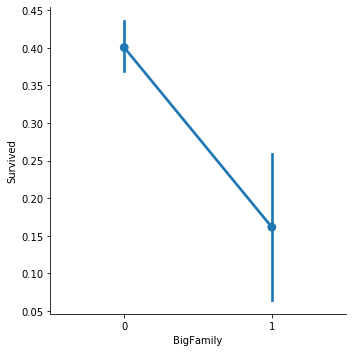

In [41]:
sns.factorplot(x='BigFamily', y='Survived', data=checkName.iloc[0:891])

In [42]:
checkName.drop(['BigFamily'], axis=1, inplace=True)

In [43]:
train_df = checkName.iloc[0:891].copy()
test_df = checkName.iloc[891:1309].copy()

In [44]:
test_df

Survived  Pclass  Sex  Age  SibSp  Parch  Embarked  Relatives  \
891        NaN       3    0   34      0      0         2          0   
892        NaN       3    1   47      1      0         0          1   
893        NaN       2    0   62      0      0         2          0   
894        NaN       3    0   27      0      0         0          0   
895        NaN       3    1   22      1      1         0          2   
...        ...     ...  ...  ...    ...    ...       ...        ...   
1304       NaN       3    0   25      0      0         0          0   
1305       NaN       1    1   39      0      0         1          0   
1306       NaN       3    0   38      0      0         0          0   
1307       NaN       3    0   25      0      0         0          0   
1308       NaN       3    0   25      1      1         1          2   

      FarePerPerson  
891               1  
892               0  
893               2  
894               2  
895               0  
...             ...  
1304              1  
1305              3  
1306              0  
1307              1  
1308              0  

[418 rows x 9 columns]

In [45]:
test_df=test_df.reset_index()
test_df.drop(['index','Survived'], axis=1, inplace=True)
test_df

Pclass  Sex  Age  SibSp  Parch  Embarked  Relatives  FarePerPerson
0         3    0   34      0      0         2          0              1
1         3    1   47      1      0         0          1              0
2         2    0   62      0      0         2          0              2
3         3    0   27      0      0         0          0              2
4         3    1   22      1      1         0          2              0
..      ...  ...  ...    ...    ...       ...        ...            ...
413       3    0   25      0      0         0          0              1
414       1    1   39      0      0         1          0              3
415       3    0   38      0      0         0          0              0
416       3    0   25      0      0         0          0              1
417       3    0   25      1      1         1          2              0

[418 rows x 8 columns]

In [46]:
train_df['Survived'] = train_df['Survived'].astype(int)
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.copy()

After we have manipulated our dataset and transformed almost all values in categories, we can start testing how good various models perform in predicting the survival of passengers.

In [58]:
train_df['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

We can see that the dataset is a bit unbalanced towards the *not_survived* category but the unbalance is not so great, therefore we can use accuracy as a first way to discriminate between the different models

In [47]:
logreg = LogisticRegression(multi_class="multinomial", max_iter=2000)
logreg.fit(X_train, Y_train)
Y_predLogReg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

In [48]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_predGauss = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

In [49]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_predDT = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

In [50]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_predRF = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [51]:
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_predSGD = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

In [52]:
#XGBOOST
xgboost = XGBClassifier()
xgboost.fit(X_train, Y_train)
Y_predXGB = xgboost.predict(X_test)
acc_xgboost = round(xgboost.score(X_train,Y_train) * 100, 2)

In [60]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Decision Tree','Random Forest','SGD','XGB'],
    'Score': [acc_log, acc_gaussian, acc_decision_tree, acc_random_forest, acc_sgd, acc_xgboost],
})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

Model
Score                     
94.50        Decision Tree
94.50        Random Forest
93.27                  XGB
81.03  Logistic Regression
76.99          Naive Bayes
70.48                  SGD

We can now check with a 10-fold cross validation method which is the model that *on average* has the highest accuracy 

In [61]:
classifiers = [logreg, gaussian, decision_tree, random_forest, sgd, xgboost]
classifiers_dict = {0: "logreg",1: "gaussian", 2:"decision_tree", 3:"random_forest", 4:"sgd", 5:"xgboost"}
for i in range(0,len(classifiers)):
    scores = cross_val_score(classifiers[i], X_train, Y_train, cv=10, scoring = "accuracy")
    print("classifier: ", classifiers_dict[i])
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    print("\n\n")

classifier:  logreg
Scores:  [0.8        0.79775281 0.76404494 0.86516854 0.83146067 0.79775281
 0.80898876 0.79775281 0.82022472 0.80898876]
Mean:  0.8092134831460674
Standard Deviation:  0.02503273957742477



classifier:  gaussian
Scores:  [0.73333333 0.71910112 0.74157303 0.73033708 0.80898876 0.73033708
 0.78651685 0.82022472 0.79775281 0.84269663]
Mean:  0.7710861423220974
Standard Deviation:  0.04271791308657779



classifier:  decision_tree
Scores:  [0.74444444 0.78651685 0.70786517 0.83146067 0.80898876 0.83146067
 0.80898876 0.74157303 0.78651685 0.84269663]
Mean:  0.7890511860174781
Standard Deviation:  0.04256515996934163



classifier:  random_forest
Scores:  [0.75555556 0.78651685 0.74157303 0.85393258 0.83146067 0.83146067
 0.83146067 0.78651685 0.86516854 0.85393258]
Mean:  0.8137578027465668
Standard Deviation:  0.041101759072893984



classifier:  sgd
Scores:  [0.65555556 0.69662921 0.76404494 0.66292135 0.80898876 0.76404494
 0.84269663 0.48314607 0.40449438 0.797752

As we can see, RandomForest and XGBoost are the models with the highest average accuracy, therefore we will continue with parameter optimisation for these two models. First of all, let's look at the feature importance for both models, dropping the least important one and checking that the model performances stay unchanged. 

In [62]:
featureImportanceRF = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
featureImportanceRF = featureImportanceRF.sort_values('importance',ascending=False).set_index('feature')

In [63]:
featureImportanceRF

importance
feature                  
Age                 0.360
Sex                 0.291
Pclass              0.090
FarePerPerson       0.086
Relatives           0.064
Embarked            0.041
SibSp               0.039
Parch               0.029

In [64]:
featureImportanceXGB = pd.DataFrame({'feature':X_train.columns,'importance':np.round(xgboost.feature_importances_,3)})
featureImportanceXGB = featureImportanceXGB.sort_values('importance',ascending=False).set_index('feature')

In [65]:
featureImportanceXGB

importance
feature                  
Sex                 0.610
Pclass              0.138
SibSp               0.066
Relatives           0.051
FarePerPerson       0.046
Age                 0.034
Embarked            0.030
Parch               0.025

In [66]:
featureImportanceRF['importance'].sum()

1.0

In [67]:
featureImportanceXGB['importance'].sum()

1.0

In [68]:
train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

In [69]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

94.5 %


In [70]:
xgboost = XGBClassifier()
xgboost.fit(X_train, Y_train)
Y_predXGB = xgboost.predict(X_test)
acc_xgboost = round(xgboost.score(X_train,Y_train) * 100, 2)
print(round(acc_xgboost,2,), "%")

93.27 %


In [71]:
classifiers = [random_forest, xgboost]
classifiers_dict = {0: "random_forest", 1:"xgboost"}
for i in range(0,len(classifiers)):
    scores = cross_val_score(classifiers[i], X_train, Y_train, cv=10, scoring = "accuracy")
    print("classifier: ", classifiers_dict[i])
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    print("\n\n")

classifier:  random_forest
Scores:  [0.73333333 0.76404494 0.73033708 0.83146067 0.83146067 0.83146067
 0.84269663 0.7752809  0.85393258 0.83146067]
Mean:  0.8025468164794007
Standard Deviation:  0.044527661295652846



classifier:  xgboost
Scores:  [0.76666667 0.82022472 0.75280899 0.83146067 0.85393258 0.82022472
 0.82022472 0.78651685 0.88764045 0.78651685]
Mean:  0.812621722846442
Standard Deviation:  0.038620044099578886





In [72]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 80.58 %


Let's now create two grid of parameters for RandomForest and XGBoost respectively, rerun the two models with each combination of parameters and see which is the set of parameters that return the highest accuracy for both models

In [73]:
param_grid_RF = { "criterion" : ["gini", "entropy"], 
                  "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
                  "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
                  "n_estimators": [100, 400, 700, 1000, 1500] }

In [74]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clfRF = GridSearchCV(estimator=rf, param_grid = param_grid_RF, n_jobs=-1, refit=True, return_train_score=True)
clfRF.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=1,
                                   

In [75]:
clfRF.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 18,
 'n_estimators': 100}

In [76]:
clfRF.best_score_

0.8271985437197916

In [77]:
param_grid_XGB = {  "min_child_weight": [1, 5, 10],
                    "gamma": [0.5, 1, 1.5, 2, 5],
                    "subsample": [0.6, 0.8, 1.0],
                    "colsample_bytree": [0.6, 0.8, 1.0],
                    "max_depth": [3, 4, 5]}

In [78]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic', silent=True, nthread=1)
clfXGB = GridSearchCV(estimator=xgb, param_grid=param_grid_XGB, n_jobs=-1, refit=True, return_train_score=True)
clfXGB.fit(X_train, Y_train)

[17:04:41] WARNING: /Users/Davide/MachineLearning/my_env/xgboost/src/learner.cc:485: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=True, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
     

In [79]:
clfXGB.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.8}

In [80]:
clfXGB.best_score_

0.8293955181721173